# Deformable Style Transfer (ECCV 2020)

In this notebook, we demonstrate deformable style transfer (DST) using STROTSS as the base style transfer method.

Project page: https://sunniesuhyoung.github.io/DST-page/  
Paper: https://arxiv.org/abs/2003.11038  
Code: https://github.com/sunniesuhyoung/DST  
1min video: https://youtu.be/7qUzfcn6TPk  
10min talk: https://youtu.be/mVU5tSxS4is

In [ ]:
!git clone https://github.com/sunniesuhyoung/DST
import os
os.chdir('DST')

Cloning into 'DST'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 54 (delta 12), reused 33 (delta 0), pack-reused 0
Unpacking objects: 100% (54/54), done.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from utils_misc import pil_loader, pil_resize_long_edge_to, pil_to_tensor

In [ ]:
# Image will be resized to have a long side of im_side
%env im_size = 256

# If you choose cuda, make sure you select GPU under [Runtime]-[Change runtime type]
%env device = cuda

env: im_size=256
env: device=cuda


## 1. Load content and style images

In [ ]:
%%shell
gdown https://drive.google.com/uc?id=1l4HebC6VUeUaCFD-EPCY4aPveKJaSClH
mkdir -p /content/data/images/initial
unzip input.zip -d /content/data/images/initial/


Downloading...
From: https://drive.google.com/uc?id=1l4HebC6VUeUaCFD-EPCY4aPveKJaSClH
To: /content/data/images/cartoons/input.zip
2.36MB [00:00, 11.1MB/s]
Archive:  input.zip
  inflating: /content/data/images/initial/2_orig.png  
  inflating: /content/data/images/initial/0_orig.png  


In [ ]:
!mkdir -p /content/data/images/cartoons
%cd /content/data/images/cartoons
!gdown --id 1YNOlaw-gY0my23X-5mZijSgLYHdDasuU
!unzip Cartoons_000.zip
!rm Cartoons_000.zip

/content/data/images/cartoons
Downloading...
From: https://drive.google.com/uc?id=1YNOlaw-gY0my23X-5mZijSgLYHdDasuU
To: /content/data/images/cartoons/Cartoons_000.zip
100% 1.23M/1.23M [00:00<00:00, 4.67MB/s]
Archive:  Cartoons_000.zip
  inflating: Cartoons_00011_01.jpg   
  inflating: Cartoons_00013_01.jpg   
  inflating: Cartoons_00013_02.jpg   
  inflating: Cartoons_00029_01.jpg   
  inflating: Cartoons_00031_01.jpg   
  inflating: Cartoons_00036_01.jpg   
  inflating: Cartoons_00038_02.jpg   
  inflating: Cartoons_00038_03.jpg   
  inflating: Cartoons_00038_07.jpg   
  inflating: Cartoons_00044_01.jpg   
  inflating: Cartoons_00047_01.jpg   


In [ ]:
# Set input image paths
%env content_path = /content/data/images/initial/0_orig.png 
%env style_path =  /content/data/images/cartoons/img3646_face0.jpeg

env: content_path=/content/data/images/initial/0_orig.png
env: style_path=/content/data/images/cartoons/img3646_face0.jpeg


Alternatively, you can upload images. (Uncomment the below three blocks.)

In [ ]:
# from google.colab import files
# content_im = files.upload()

In [ ]:
# style_im = files.upload()

In [ ]:
# os.environ['content_path'] = list(content_im)[0]
# os.environ['style_path'] = list(style_im)[0]

Back to the common code section.

In [ ]:
# Load and resize input images
content_pil = pil_resize_long_edge_to(pil_loader(os.environ['content_path']), int(os.environ['im_size']))
width, height = content_pil.size
style_pil = pil_resize_long_edge_to(pil_loader(os.environ['style_path']), int(os.environ['im_size']))
content_im_orig = pil_to_tensor(content_pil).to(os.environ['device'])
style_im_orig = pil_to_tensor(style_pil).to(os.environ['device'])

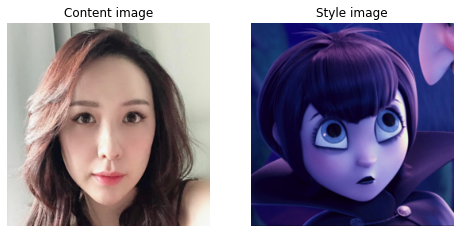

In [ ]:
# Plot images
fig = plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(content_pil); plt.axis('off'); plt.title('Content image');
plt.subplot(1, 2, 2)
plt.imshow(style_pil); plt.axis('off'); plt.title('Style image');

## 2. Find matching points with Neural Best-Buddies

Run NBB to find correspondences between images. This will take about a minute or two to run. 

If you have matching points, you can skip this step.

In [ ]:
%cd /content/DST

/content/DST


In [ ]:
# Set where you want NBB results to be saved
%env pts_path = example/NBBresults

env: pts_path=example/NBBresults


In [ ]:
# Run NBB
!python NBB/main.py --results_dir ${pts_path} --imageSize ${im_size} --fast \
  --datarootA ${content_path} --datarootB ${style_path}



---------------------------
Started Neural Best-Buddies
---------------------------
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)

Finding best-buddies for the 5-th level
Scaling and drawing correspondence...

Finding best-buddies for the 4-th level
Scaling and drawing correspondence...

Finding best-buddies for the 3-th level
Scaling and drawing corres

## 3. Clean (NBB) points

If you're cleaning NBB points, set **NBB** to 1. This script will filter out points with low activations and select up to **max_num_points** with at least **b** space between them. Then it will remove crossing points.

If you're not cleaning NBB points, set **NBB** to 0, and this script will only remove crossing points. 

This will take a few seconds to run.

In [ ]:
# Set paths and other parameters for cleaning points
%env content_pts_path = example/NBBresults/correspondence_A.txt
%env style_pts_path = example/NBBresults/correspondence_B.txt
%env activation_path = example/NBBresults/correspondence_activation.txt
%env output_path = example/CleanedPts
%env NBB = 1
%env max_num_points = 80
%env b = 10

env: content_pts_path=example/NBBresults/correspondence_A.txt
env: style_pts_path=example/NBBresults/correspondence_B.txt
env: activation_path=example/NBBresults/correspondence_activation.txt
env: output_path=example/CleanedPts
env: NBB=1
env: max_num_points=80
env: b=10


In [ ]:
!python cleanpoints.py ${content_path} ${style_path} ${content_pts_path} ${style_pts_path} \
  ${activation_path} ${output_path} ${im_size} ${NBB} ${max_num_points} ${b}



--------------------------
Started Cleaning Keypoints
--------------------------

Settings
   content_path: /content/data/images/initial/0_orig.png
   style_path: /content/data/images/cartoons/img3646_face0.jpeg
   content_pts_path: example/NBBresults/correspondence_A.txt
   style_pts_path: example/NBBresults/correspondence_B.txt
   activation_path: example/NBBresults/correspondence_activation.txt
   output_path: example/CleanedPts
   NBB: True
   im_size: 256
   max_num_points: 80
   b: 10

Started with 494 points

4 points removed because their activations were less than 1 (NBB-specific processing)

41 points selected in a greedy way (NBB-specific processing)

39 points remaining after removing crossing points

Saved cleaned content points at example/CleanedPts/correspondence_A.txt
Saved cleaned style points at example/CleanedPts/correspondence_B.txt
Saved cleaned activations at example/CleanedPts/correspondence_activation.txt

Finished after 2.755 seconds


In [ ]:
%env content_marked = example/CleanedPts/A_selected_final.png
%env style_marked = example/CleanedPts/B_selected_final.png

env: content_marked=example/CleanedPts/A_selected_final.png
env: style_marked=example/CleanedPts/B_selected_final.png


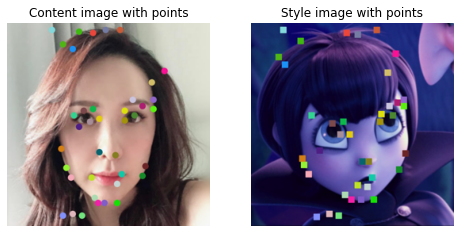

In [ ]:
# Load and plot images with points marked
content_marked_pil = pil_resize_long_edge_to(pil_loader(os.environ['content_marked']), int(os.environ['im_size']))
style_marked_pil = pil_resize_long_edge_to(pil_loader(os.environ['style_marked']), int(os.environ['im_size']))

fig = plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(content_marked_pil); plt.axis('off'); plt.title('Content image with points');
plt.subplot(1, 2, 2)
plt.imshow(style_marked_pil); plt.axis('off'); plt.title('Style image with points');

## 4. Run DST

Finally, run deformable style transfer. Stylization will take a few minutes.

By default, DST will stylize the image at three scales (small to big) with **max_iter** iterations at each scale. Change **content_weight** (alpha) and **warp_weight** (beta) to control the relative importance of content preservation and spatial deformation to stylization, and **reg_weight** (gamma) to control the amount of regularization on the deformation.

Set **verbose** to 1 to get the individual loss term values during training.  
Set **save_intermediate** to 1 to get intermediate stylized images every **checkpoint_iter** iterations.  
Set **save_extra** to 1 to get additional plots (e.g. content/stylized images naively warped, content image with DST warp) with points and arrows marked.

In [ ]:
%env content_pts_path = example/CleanedPts/correspondence_A.txt
%env style_pts_path = example/CleanedPts/correspondence_B.txt
%env output_dir = example/DSTresults
%env output_prefix = example
%env max_iter = 250
%env checkpoint_iter = 50
%env content_weight = 8
%env warp_weight = 0.5
%env reg_weight = 50
%env optim = sgd
%env lr = 0.2
%env verbose = 0
%env save_intermediate = 0
%env save_extra = 0

env: content_pts_path=example/CleanedPts/correspondence_A.txt
env: style_pts_path=example/CleanedPts/correspondence_B.txt
env: output_dir=example/DSTresults
env: output_prefix=example
env: max_iter=250
env: checkpoint_iter=50
env: content_weight=8
env: warp_weight=0.5
env: reg_weight=50
env: optim=sgd
env: lr=0.2
env: verbose=0
env: save_intermediate=0
env: save_extra=0


In [ ]:
!python -W ignore main.py ${content_path} ${style_path} ${content_pts_path} ${style_pts_path} \
  ${output_dir} ${output_prefix} ${im_size} ${max_iter} \
  ${checkpoint_iter} ${content_weight} ${warp_weight} ${reg_weight} ${optim} \
  ${lr} ${verbose} ${save_intermediate} ${save_extra} ${device}



---------------------------------
Started Deformable Style Transfer
---------------------------------

Settings
   content_path: /content/data/images/initial/0_orig.png
   style_path: /content/data/images/cartoons/img3646_face0.jpeg
   content_pts_path: example/CleanedPts/correspondence_A.txt
   style_pts_path: example/CleanedPts/correspondence_B.txt
   output_dir: example/DSTresults
   output_prefix: example
   im_size: 256
   max_iter: 250
   checkpoint_iter: 50
   content_weight: 8.0
   warp_weight: 0.5
   reg_weight: 50.0
   optim: sgd
   lr: 0.2
   verbose: False
   save_intermediate: False
   save_extra: False

Optimizing at scale 1, image size (64, 64)
   STEP 000: Loss 12.025
   STEP 050: Loss 9.924
   STEP 100: Loss 9.332
   STEP 150: Loss 8.907
   STEP 200: Loss 8.556

Optimizing at scale 2, image size (128, 128)
   STEP 000: Loss 9.688
   STEP 050: Loss 7.318
   STEP 100: Loss 7.033
   STEP 150: Loss 6.858
   STEP 200: Loss 6.715

Optimizing at scale 3, image size (256, 25

In [ ]:
%env result_path = example/DSTresults/example.png

env: result_path=example/DSTresults/example.png


In [ ]:
# Load the output image
result_pil = pil_resize_long_edge_to(pil_loader(os.environ['result_path']), int(os.environ['im_size']))

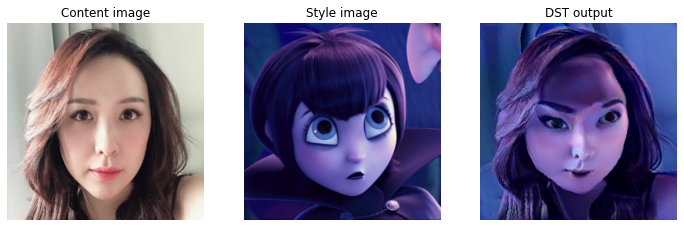

In [ ]:
# Plot input and output images
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(content_pil); plt.axis('off'); plt.title('Content image');
plt.subplot(1, 3, 2)
plt.imshow(style_pil); plt.axis('off'); plt.title('Style image');
plt.subplot(1, 3, 3)
plt.imshow(result_pil); plt.axis('off'); plt.title('DST output');

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


# style_img = image_loader(style_image_path)
# content_img = image_loader(content_image_path)

# assert style_img.size() == content_img.size(), \
#     "we need to import style and content images of the same size"

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


# plt.figure()
# imshow(style_img, title='Style Image')

# plt.figure()
# imshow(content_img, title='Content Image')

In [ ]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


# style_img = image_loader(style_image_path)
# content_img = image_loader(content_image_path)

# assert style_img.size() == content_img.size(), \
#     "we need to import style and content images of the same size"

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


# plt.figure()
# imshow(style_img, title='Style Image')

# plt.figure()
# imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    # print(model)
    return model, style_losses, content_losses

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    try:
      print("style_losses", [loss.value for loss in style_losses])
      print("content_losses", [loss.value for loss in content_losses])
    except Exception:
      pass

    run = [0]
    
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight
            
            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
            
            if loss > previous_loss:
                return 0
            
            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
from os import listdir
from os.path import isfile, join

content_image_path = "/content/DST/example/DSTresults/example.png"  #@param {"type": "string"}

style_image_path = "/content/data/images/cartoons/img3691_face0.jpeg"  #@param {"type": "string"}


In [ ]:
def process_image(content_image_path, style_image_path):
  style_img = image_loader(style_image_path)
  content_img = image_loader(content_image_path)

  assert style_img.size() == content_img.size(), \
      "we need to import style and content images of the same size"

  # model, style_losses, content_losses = get_style_model_and_losses(cnn,
  #       cnn_normalization_mean, cnn_normalization_std, style_img, content_img)
  # optimizer = get_input_optimizer(content_img)
  output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                              content_img, style_img, content_img)

  plt.figure()
  imshow(output, title='Output Image')

  # sphinx_gallery_thumbnail_number = 4
  plt.ioff()
  plt.show()

process_image(content_image_path, style_image_path)

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


UnboundLocalError: ignored